In [54]:
import os
from functools import partial
from typing import (
  Tuple, List, Dict, Any, Sequence, Callable)

import jax
import jax.numpy as jnp
import jax.random as jr 
import haiku as hk
import jraph
import optax
import numpy as np
import matplotlib.pyplot as plt

from mnist_to_graphs import pad_graph_to_value

#### globals

In [55]:
Array = jnp.ndarray
Graph = jraph.GraphsTuple
Params = hk.Params

N_GRAPHS = 2000 # = n_sims
BATCH_SIZE = 8
N_STEPS = 10_000
PAD_VALUE = 8128 
F = 8 
E = 8 

#### data

In [56]:
def get_R_z_string(R_values, z_values, n_moments_calculate=3):
    if isinstance(R_values, list):
        if len(R_values) == len(all_R_values):
            R_string = "all"
        else:
            R_string = "_".join([str(float(R)) for R in R_values])
    else:
        R_string = str(R_values)
    if isinstance(z_values, list):
        if len(z_values) == len(all_redshifts):
            z_string = "all"
        else:
            z_string = "_".join([str(float(z)) for z in z_values])
    else:
        z_string = str(z_values)

    return f"x={resolution}_R={R_string}_z={z_string}_nm={n_moments_calculate}"

prng_seq = hk.PRNGSequence(0)

data_dir = "/Users/Jed.Homer/phd/lfi/jaxdelfi/data/"
resolution = 1024 
all_redshifts = [0., 0.5, 1., 2., 3.]
all_R_values = ["5.0", "10.0", "15.0", "20.0", "25.0", "30.0"]

redshifts = all_redshifts[:3]
R_values = all_R_values[:4]

R_idx = [all_R_values.index(R) for R in R_values]
z_idx = [redshifts.index(z) for z in redshifts]

print(f"Running for redshifts:\n{redshifts}\nat resolution x={resolution} with R values:\n{R_values}.")

Rz_string = get_R_z_string(R_values, redshifts, n_moments_calculate=3)

Running for redshifts:
[0.0, 0.5, 1.0]
at resolution x=1024 with R values:
['5.0', '10.0', '15.0', '20.0'].


In [57]:
# # (z, n, d, R)
# all_pdfs = np.load(
#     "/Users/Jed.Homer/phd/lfi/jaxdelfi_pdf/data/ALL_PDFS_1024_egg.npy") # downloaded again
# all_pdfs_parameters = np.load(
#     os.path.join(data_dir, "ALL_PDFS_PARAMS.npy"))

# print(all_pdfs.shape)

# all_pdfs_z = jnp.stack([all_pdfs[z] for z in z_idx])
# all_pdfs_z_R = jnp.stack([all_pdfs_z[..., R] for R in R_idx], axis=-1)
# all_pdfs_z_R = all_pdfs_z_R.reshape(2000, 3, -1)
# # all_pdfs_z_R = np.moveaxis(all_pdfs_z_R, 1, 0)

# all_pdfs_z_R.shape

#### data
* for each moments datavector, make fully connected subgraph for each redshift, then concatenate all the redshift graphs together...

In [58]:
alpha = jnp.array([
    0.3175, 0.049, 0.6711, 0.9624, 0.834])
parameters = jnp.load(
    os.path.join(data_dir, f"ALL_PDFS_PARAMS.npy")) 
simulations = jnp.load(
    os.path.join(data_dir, f"CALCULATED_PDF_MOMENTS_{Rz_string}.npy"))
fiducial_dv = jnp.load(
    os.path.join(data_dir, f'fiducial_moments_unflat_{Rz_string}.npy')).mean(axis=0)

n_sims, parameter_dim = parameters.shape
data_dim = np.prod(fiducial_dv.shape)

parameters.shape, simulations.shape, fiducial_dv.shape

((2000, 5), (2000, 3, 4, 3), (3, 4, 3))

In [59]:
# simulations = all_pdfs_z_R
# data_dim = np.prod(simulations.shape[1:])

In [60]:
def make_subgraphs(moments):
    # Vmapping, so this is z-axis
    all_g_z = []
    for z, mz in enumerate(moments):
        # print(mz.shape, np.prod(mz.shape))
        z_ = jnp.asarray([redshifts[z]])
        g_z = jraph.get_fully_connected_graph(
            # Concatenate redshift information to nodes
            node_features=jnp.concatenate([z_, mz.flatten()]),
            n_node_per_graph=np.prod(mz.shape) + 1,
            n_graph=1,
            #global_features=parameters, # maybe just parameters for main_graph not subgraphs?
            add_self_edges=False)
        all_g_z.append(g_z)
    return all_g_z 

def make_graph_from_subgraphs(subgraphs, parameters):
    """ 
        Make ONE graph from fully connected redshift-subgraphs
        - NO connections between subgraphs of different redshift
    """
    return jraph.GraphsTuple(
        nodes=jnp.concatenate([g_z.nodes for g_z in subgraphs])[:, None],
        edges=None, # edges=jnp.concatenate([g_z.edges for g_z in subgraphs]), # edge FEATURES not senders/receivers
        # Since graph is made of subgraphs, need to re-index S and R for main_graph indexing...
        senders=jnp.concatenate(
            [g_z.n_node * n + g_z.senders for n, g_z in enumerate(subgraphs)]),# senders=jnp.concatenate([g_z.senders for g_z in subgraphs]),
        receivers=jnp.concatenate(
            [g_z.n_node * n + g_z.receivers for n, g_z in enumerate(subgraphs)]),# receivers=jnp.concatenate([g_z.receivers for g_z in subgraphs]),
        n_node=sum([g_z.n_node for g_z in subgraphs]),
        n_edge=sum([g_z.n_edge for g_z in subgraphs]),
        globals=parameters)#[None, :] if parameters.ndim == 1 else parameters)

In [61]:
subgraphs = make_subgraphs(fiducial_dv)
main_graph = make_graph_from_subgraphs(subgraphs, alpha)
main_graph.nodes.shape, main_graph.edges, main_graph.globals, main_graph.senders.shape, main_graph.receivers.shape, main_graph.globals.shape

/Users/Jed.Homer/miniconda3/envs/jraph/lib/python3.10/site-packages/jraph/_src/utils.py:882: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  num_node_features = jax.tree_leaves(node_features)[0].shape[0]


((39, 1),
 None,
 DeviceArray([0.3175, 0.049 , 0.6711, 0.9624, 0.834 ], dtype=float32),
 (468,),
 (468,),
 (5,))

In [62]:
main_graph.senders.max()

DeviceArray(38, dtype=int32)

In [63]:
def adjacency_matrix(sender_indices, receiver_indices, n_nodes=None):
    # Determine the number of nodes in the graph if not provided
    if n_nodes is None:
        n_nodes = max(max(sender_indices), max(receiver_indices)) + 1

    # Create an empty adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))

    # Set entries in the adjacency matrix for each edge
    for sender, receiver in zip(sender_indices, receiver_indices):
        adj_matrix[sender, receiver] = adj_matrix[receiver, sender] = 1 

    return adj_matrix

In [64]:
attrs = ["nodes", "edges", "senders", "receivers", "globals", "n_node", "n_edge"]

for a in attrs:
    val = getattr(main_graph, a)
    print(a, val.shape if val is not None else None)

nodes (39, 1)
edges None
senders (468,)
receivers (468,)
globals (5,)
n_node (1,)
n_edge (1,)


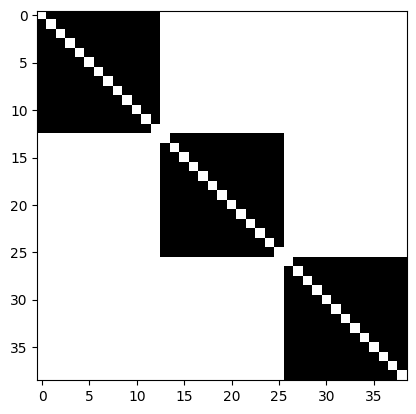

In [65]:
# Expect three squares on diagonal: FULLY connected subgraphs
A = adjacency_matrix(main_graph.senders, main_graph.receivers)
plt.imshow(A, cmap="gray_r")
plt.show()

#### model

##### resnet

In [66]:
layernorm_kwargs = dict(axis=1, create_scale=True, create_offset=True)

class LinearResNet(hk.Module):
  def __init__(
    self, 
    hidden_sizes: Sequence[int],
    activation: Callable = jax.nn.leaky_relu,
    activate_final: bool = False):
    super().__init__()
    self.hidden_sizes = hidden_sizes
    self.activation = activation
    self.activate_final = activate_final
    self.dropout_rate = 0.1

  def __call__(self, x, inference=False):
    z = x
    for f in self.hidden_sizes:
      h = self.activation(z)
      h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f)(h)
    #   if not inference:
    #     h = hk.dropout(hk.next_rng_key(), self.dropout_rate, h)
      h = self.activation(h)
      h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f, w_init=jnp.zeros)(h)
    #   if not inference:
    #     h = hk.dropout(hk.next_rng_key(), self.dropout_rate, h)
      z = z + h 
    return self.activation(z) if self.activate_final else z

##### gnn

In [67]:
def net_fn(x, inference=False):
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F], activation=jax.nn.tanh)])
  return net(x)

# @jraph.concatenated_args
def edge_update_fn(feats: Array, inference=True) -> Array:
  """ Edge update function for graph net. """
  # net = hk.Sequential([
  #  hk.Linear(F), LinearResNet([F, F, F], activation=jax.nn.tanh)])
  # return net(feats)
  return net_fn(feats, inference)

def edge_update_fn_(nodes, receivers, globals, inference=True):
  return net_fn(
    jnp.concatenate([nodes, receivers, globals], axis=1),
    inference=inference)

key = jr.PRNGKey(0)
e = hk.without_apply_rng(
  hk.transform(edge_update_fn_))
    # jraph.concatenated_args(
    #   partial(edge_update_fn, inference=True))))

x = jnp.ones((3, 2))
p = e.init(key, x, x, x)
e.apply(p, x, x, x, inference=True).shape

(3, 8)

In [68]:
def net_fn(x, inference=False):
  net = hk.Sequential([
    hk.Linear(F), 
    LinearResNet(
      [F, F, F], activation=jax.nn.tanh)])
  return net(x)

def get_edge_update_fn(inference):
    net_fn_ = partial(net_fn, inference=inference)
    return jraph.concatenated_args(net_fn_)

edge_update_fn_ = get_edge_update_fn(inference=True)

key = jr.PRNGKey(0)
e = hk.without_apply_rng(hk.transform(edge_update_fn_))

x = jnp.ones((3, 2))
p = e.init(key, x)
e.apply(p, x).shape

(3, 8)

In [69]:
@jraph.concatenated_args
def edge_update_fn(feats: Array) -> Array:
  """ Edge update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F], activation=jax.nn.tanh)])
    # hk.Linear(F), hk.nets.MLP([F, F, F], activation=jax.nn.tanh)])
  return net(feats)

@jraph.concatenated_args 
def node_update_fn(feats: Array) -> Array:
  """ Node update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F], activation=jax.nn.tanh)])
    # hk.Linear(F), hk.nets.MLP([F, F, F], activation=jax.nn.tanh)])
  return net(feats)
#   h = hk.Linear(F)(feats)
#   h = LinearResNet(
#     [F, F, F], activation=jax.nn.tanh
#   )(h, inference=False)
#   return h

@jraph.concatenated_args
def update_global_fn(feats: Array) -> Array:
#def update_global_fn(feats: Array, inference: bool = False) -> Array:
  """ Global update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), 
    LinearResNet([F, F, F], activation=jax.nn.tanh, activate_final=True),
    # hk.nets.MLP([F, F, F], activation=jax.nn.tanh, activate_final=True),
    hk.Linear(parameter_dim, with_bias=True)]) # output summary of parameter dim
  return net(feats)
#   h = hk.Linear(F)(feats)
#   h = LinearResNet(
#     [F, F, F], activation=jax.nn.tanh, activate_final=True
#   )(h, inference=False)
#   h = hk.Linear(parameter_dim, with_bias=True)(h)
#   return h

def LayerNormLinear(x):
    return hk.Linear(E, with_bias=False)(hk.LayerNorm(**layernorm_kwargs)(x))

def net_fn(graph: Graph, inference: bool = False) -> Graph:
  """ 
    Default aggregator functions for edges, global edges, global nodes 
    are "segment_sum"
  """
  embedder = jraph.GraphMapFeatures(
    embed_node_fn=LayerNormLinear, # embed_edge_fn=LayerNormLinear, 
    embed_global_fn=LayerNormLinear) 
#   net = jraph.GraphNetwork(
#     update_node_fn=node_update_fn, # update_edge_fn=edge_update_fn,
#     update_edge_fn=None,
#     update_global_fn=update_global_fn)
  graph = embedder(graph)
#   for _ in range(3):
  node_update_fn_ = jraph.concatenated_args(
    partial(node_update_fn, inference=inference))
  node_update_fn_ = partial(jraph.concatenated_args(node_update_fn), inference=inference)

  update_global_fn_ = jraph.concatenated_args(
    partial(update_global_fn, inference=inference))
  net = jraph.GraphNetwork(
    update_node_fn=node_update_fn,#partial(node_update_fn, inference=inference), # update_edge_fn=edge_update_fn,
    update_edge_fn=None,
    update_global_fn=update_global_fn)#partial(update_global_fn, inference=inference))
  graph = net(graph)
  return graph
  #return net(embedder(graph)) 

#### train

#### trainer functions

In [70]:
dataset_processed = []
for n in range(N_GRAPHS):
    l = parameters[n]
    g_z = make_subgraphs(simulations[n]) 
    g = make_graph_from_subgraphs(g_z, l[None, :]) # pointless 'l' here it is removed later anyway...
    dataset_processed.append(dict(input_graph=g, target=l))
    
    # IMPORTANT CAN NEED THIS IN DICT ABOVE FOR TARGET=L#[None, :]))

In [71]:
g = dataset_processed[0]["input_graph"]
for a in attrs:
    val = getattr(g, a)
    print(a, val.shape if val is not None else None)

nodes (39, 1)
edges None
senders (468,)
receivers (468,)
globals (1, 5)
n_node (1,)
n_edge (1,)


In [72]:
gs, ls = [], []
for _ in range(5):
    gl = dataset_processed[_]
    g, l = gl.values()
    gs.append(g), ls.append(l)

g_all = jraph.batch(gs)
print([g.nodes.shape for g in gs])
g_all.nodes.shape
print(g_all.n_node)
print(g_all.n_edge)

for a in attrs:
    val = getattr(g_all, a)
    print(a, val.shape if val is not None else None)

[(39, 1), (39, 1), (39, 1), (39, 1), (39, 1)]
[39 39 39 39 39]
[468 468 468 468 468]
nodes (195, 1)
edges None
senders (2340,)
receivers (2340,)
globals (5, 5)
n_node (5,)
n_edge (5,)


In [73]:
dataset_processed[0]["target"].shape
len(dataset_processed)

2000

In [74]:
def compute_loss(
  params: Params, 
  graph: Graph, 
  label: Array,
  net: Graph,
  inference: bool = False) -> Tuple[Array, Array]:
  pred_graph = net.apply(params, graph, inference=inference)
  preds = pred_graph.globals
  mask = jraph.get_graph_padding_mask(pred_graph)
  loss = (jnp.square(jnp.subtract(preds, label)) * mask[:, None]).mean()
  return loss, (None,)
 

def get_graphs(key, dataset):
    if BATCH_SIZE > 1:
        idx = jr.randint(key, shape=(BATCH_SIZE,), minval=0, maxval=len(dataset))
        gs, ls = [], []
        for i in idx:
            g, l = dataset[int(i)].values()
            gs.append(g), ls.append(l)
        graph = jraph.batch(gs)
        label = jnp.stack(ls)
    else:
        idx = int(jr.randint(key, shape=(1,), minval=0, maxval=len(dataset)))
        graph, label = dataset[idx].values()
    label = jnp.concatenate([label, jnp.zeros((1, parameter_dim))])
    return graph, label


def train(
  dataset: List[Dict[str, Any]], 
  num_train_steps: int) -> Tuple[hk.Params, List, List]:

  key = jr.PRNGKey(0)

  net = hk.without_apply_rng(hk.transform(net_fn))

  train_dataset = [
    dataset[t] for t in range(int(0.9 * N_GRAPHS))]
  valid_dataset = [
    dataset[-v] for v in range(int(0.1 * N_GRAPHS))]#range(N_GRAPHS, int(0.9 * N_GRAPHS), -1)]

  graph = train_dataset[0]['input_graph']
  graph = pad_graph_to_value(graph, PAD_VALUE)
  params = net.init(key, graph)

  print(f"n_params = {sum(x.size for x in jax.tree_util.tree_leaves(params)):.2E}")

  # Initialize the optimizer.
  opt_init, opt_update = optax.adabelief(2e-4)
  opt_state = opt_init(params)

  compute_loss_ = partial(compute_loss, net=net, inference=False)
  compute_loss_fn = jax.jit(
    jax.value_and_grad(compute_loss_, has_aux=True))
  eval_fn = jax.jit(partial(compute_loss, net=net, inference=False))

  train_losses, valid_losses = [], []
  for s in range(num_train_steps):
    key, key_idx = jr.split(key)

    # Train
    graph, label = get_graphs(key_idx, train_dataset)
    graph = pad_graph_to_value(graph, PAD_VALUE)
    (train_loss, (_)), grad = compute_loss_fn(params, graph, label)

    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

    # Validate
    graph, label = get_graphs(key_idx, valid_dataset)
    graph = pad_graph_to_value(graph, PAD_VALUE)
    valid_loss, _ = eval_fn(params, graph, label)

    if s % 100 == 0:
      print(f'\rstep: {s:06d}, L: {train_loss:.4f} L_v: {valid_loss:.4f}', end="")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

  print('Training finished')
  return params, train_losses, valid_losses 

#### check

In [75]:
print([_.shape for _ in g_all if _ is not None])

[(195, 1), (2340,), (2340,), (5, 5), (5,), (5,)]


In [76]:
key = jr.PRNGKey(0)
key, _ = jr.split(key)

net = hk.without_apply_rng(hk.transform(net_fn))

graph = pad_graph_to_value(g_all, PAD_VALUE)
print(graph.globals, graph.globals.shape)

params = net.init(key, g_all)

y_ = net.apply(params, g_all)
print("net out", y_.globals.shape)

mask = jraph.get_graph_padding_mask(y_)
print(mask)

jnp.argmax(y_.globals[mask], axis=1), l.argmax()

[[0.1755  0.06681 0.7737  0.8849  0.6641 ]
 [0.2139  0.05557 0.8599  0.9785  0.8619 ]
 [0.1867  0.04503 0.6189  0.8307  0.7187 ]
 [0.3271  0.06875 0.6313  0.8135  0.8939 ]
 [0.1433  0.06347 0.6127  1.1501  0.7699 ]
 [0.      0.      0.      0.      0.     ]] (6, 5)
net out (5, 5)
[ True  True  True  True False]


(DeviceArray([0, 0, 0, 0], dtype=int32), DeviceArray(3, dtype=int32))

In [77]:
key = jr.PRNGKey(0)
key, _ = jr.split(key)

net = hk.without_apply_rng(hk.transform(net_fn))

ix1, ix2 = jr.randint(key, (2,), 0, len(dataset_processed))

graph = dataset_processed[ix1]['input_graph']
l = dataset_processed[ix1]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print(graph.globals, graph.globals.shape)

for a in attrs:
    val = getattr(graph, a)
    print(a, val.shape if val is not None else None)

params = net.init(key, graph)

graph = dataset_processed[ix2]['input_graph']
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)

y_ = net.apply(params, graph)
print("net out", y_.globals.shape)

mask = jraph.get_graph_padding_mask(y_)
print(mask)

jnp.argmax(y_.globals[mask], axis=1), l.argmax()

[[0.2497  0.06921 0.8915  1.0937  0.6587 ]
 [0.      0.      0.      0.      0.     ]] (2, 5)
nodes (8129, 1)
edges None
senders (8128,)
receivers (8128,)
globals (2, 5)
n_node (2,)
n_edge (2,)
net out (2, 5)
[ True False]


(DeviceArray([0], dtype=int32), DeviceArray(3, dtype=int32))

In [78]:
graph = dataset_processed[ix2]['input_graph']
print("before pad", graph.nodes.shape, graph.globals.shape)
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print("after pad", graph.nodes.shape, graph.globals.shape)

before pad (39, 1) (1, 5)
after pad (8129, 1) (2, 5)


In [79]:
dataset_processed[0]["target"].shape

(5,)

In [80]:
params, train_losses, valid_losses = train(dataset_processed, num_train_steps=N_STEPS)

n_params = 1.43E+03
step: 009900, L: 0.0077 L_v: 0.0049Training finished


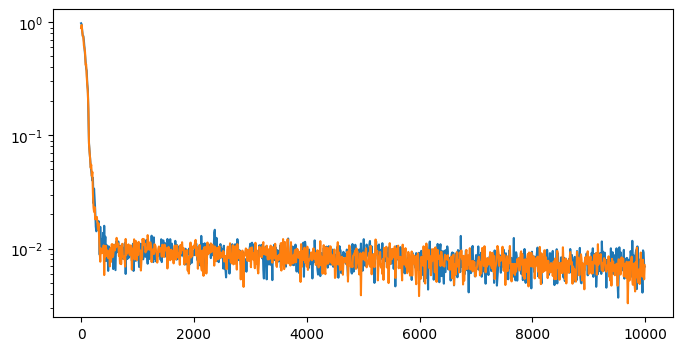

In [81]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8.,4.))
steps = range(0, N_STEPS, 10)
ax.semilogy(steps, train_losses[::10])
ax.semilogy(steps, valid_losses[::10])
plt.show()

In [82]:
graphs = []
for gl in dataset_processed:
    g, l = gl.values()
    graphs.append(g)

all_graphs = jraph.batch(graphs)
for a in attrs:
    val = getattr(all_graphs, a)
    print(a, val.shape if val is not None else None)

nodes (78000, 1)
edges None
senders (936000,)
receivers (936000,)
globals (2000, 5)
n_node (2000,)
n_edge (2000,)


In [83]:
fiducial_subgraphs = make_subgraphs(fiducial_dv)
fiducial_graph = make_graph_from_subgraphs(fiducial_subgraphs, alpha[None, :])

In [84]:
all_graphs_out = net.apply(params, all_graphs)
fiducial_graph_out = net.apply(params, fiducial_graph)
preds = all_graphs_out.globals
fiducial_preds = fiducial_graph_out.globals
fiducial_preds.shape 

(1, 5)

In [85]:
# List of graphs
# unbatched_graphs = jraph.unbatch(all_graphs_out)

senders and receivers are constant through application of graph interaction network

In [86]:
# A = adjacency_matrix(unbatched_graphs[0].senders, unbatched_graphs[0].receivers)
# plt.imshow(A, cmap="gray_r")
# plt.show()

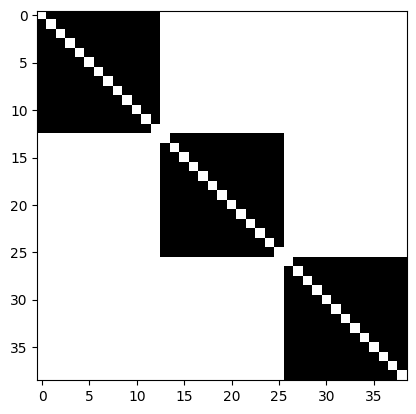

In [87]:
A = adjacency_matrix(fiducial_graph_out.senders, fiducial_graph_out.receivers)
plt.imshow(A, cmap="gray_r")
plt.show()

(2000, 2) (2000, 2)


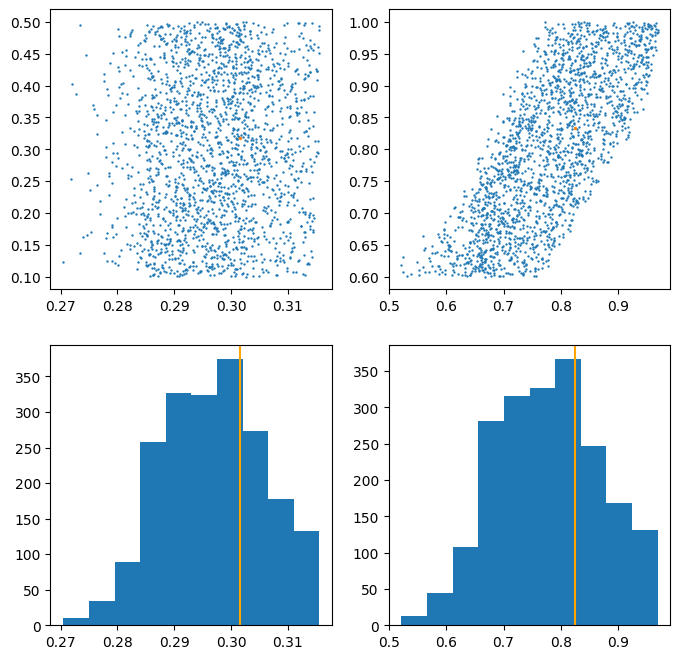

In [88]:
target_idx = jnp.array([0, 4])
pred_targets = preds[:, target_idx]
parameter_targets = parameters[:N_GRAPHS, target_idx]

print(pred_targets.shape, parameter_targets.shape)

fig, axs = plt.subplots(2, 2, figsize=(8., 8.), dpi=100)
ax = axs[0, 0]

ax.scatter(pred_targets[:, 0], parameter_targets[:, 0], s=0.5)
ax.scatter(fiducial_preds[:, 0], alpha[None, :][:, 0], s=2.)
ax = axs[0, 1]
ax.scatter(pred_targets[:, 1], parameter_targets[:, 1], s=0.5)
ax.scatter(fiducial_preds[:, 4], alpha[None, :][:, 4], s=2.)
ax = axs[1, 0]
ax.hist(pred_targets[:, 0])
ax.axvline(fiducial_preds[:, 0], color="orange")
ax = axs[1, 1]
ax.hist(pred_targets[:, 1])
ax.axvline(fiducial_preds[:, 4], color="orange")
plt.show()

In [89]:
fiducial_preds.shape

(1, 5)

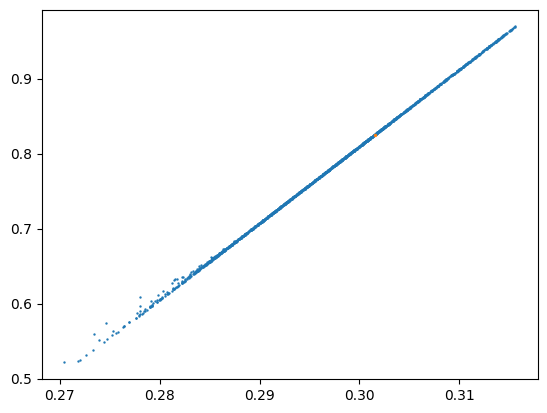

In [90]:
plt.figure()
plt.scatter(*pred_targets.T, s=0.5)
plt.scatter(*fiducial_preds[:, target_idx].T, s=2.)
plt.show()